In [83]:
import re
import os
import pickle
import re
import string
from collections import defaultdict, Counter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
import nltk
from nltk.tokenize import RegexpTokenizer, sent_tokenize
import scattertext as st
import spacy
import pyLDAvis.gensim
import pyLDAvis.sklearn
from datetime import datetime
from gensim import corpora, models, similarities, matutils
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.decomposition import NMF, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
import plotly.plotly as py
import plotly.graph_objs as go
import plotly.tools
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot 
import textstat

In [84]:
path = 'corpora/Clinton-Trump Corpus'

In [85]:
# get list of files for each candidate from corpus

dirs, hils, trumps = os.walk(path, topdown=True)    

In [86]:
# make a dictionary of the date, title, and content of speech from list of files

def make_dict(files):
    d = defaultdict(str)
    directory = files[0]+'/'
    for f in files[2]:
        
        path = directory + f    #read file
        file = open(path, 'r')
        text =  file.read()
        date = re.findall(r'(<=?date:)(.*)(?=>)',text)[0][1]    #extract date, title, and speech
        title = re.findall(r'(<=?title=)(.*)(?=>)',text)[0][1]
        cleaned = re.sub(r"[<\n].*?[>]",'', text)
        cleaned = re.sub(r"[0-9]","",cleaned)
        d[f] = {'date':date,'title':title,'speech': cleaned}
    return dict(d)

In [129]:
# make DataFrame of speeches

trumpdf = pd.DataFrame.from_dict(make_dict(trumps)).transpose()
hillarydf = pd.DataFrame.from_dict(make_dict(hils)).transpose()

hillarydf['candidate'] = 'clinton'
trumpdf['candidate'] = 'trump'

speechdf = pd.concat([hillarydf, trumpdf])

speechdf.date = pd.to_datetime(speechdf.date, format='"%Y-%m-%d"')
speechdf.speech = speechdf.speech.apply(lambda x: re.sub("[^\w ]" ,'',x))  ## remove all punctuation

<>:12: DeprecationWarning:

invalid escape sequence \w

<>:12: DeprecationWarning:

invalid escape sequence \w

<>:12: DeprecationWarning:

invalid escape sequence \w

<ipython-input-129-5cf766c982e4>:12: DeprecationWarning:

invalid escape sequence \w



In [88]:
with open('debate_1.pkl', 'rb') as handle:
    debate_1 = pickle.load(handle)
with open('debate_2.pkl', 'rb') as handle:
    debate_2 = pickle.load(handle)
with open('debate_3.pkl', 'rb') as handle:
    debate_3 = pickle.load(handle)
    
debatesdf = pd.concat([debate_1, debate_2, debate_3], ignore_index=True)

In [89]:
with open('trump_all.pkl', 'rb') as handle:
    trump_all = pickle.load(handle)

# EDA

## Clinton vs Trump avg word length and sentence length

In [77]:
trumpspeeches = speechdf.loc[(speechdf.candidate == 'trump'),'speech'].tolist()
trumpdebates = debatesdf.loc[(debatesdf.candidate == 'trump'),'args'].tolist()
trumpspeeches.extend(trumpdebates)
#trumpwords = ' '.join(trumpspeeches).split()
trumpsentences = ' '.join(trumpspeeches)
trumpsent_tokens = sent_tokenize(trumpsentences)



hilspeeches = speechdf.loc[(speechdf.candidate == 'clinton'),'speech'].tolist()
hildebates = debatesdf.loc[(debatesdf.candidate == 'clinton'),'args'].tolist()
hilspeeches.extend(trumpdebates)
#hilwords = ' '.join(hilspeeches).split()
hilsentences = ' '.join(hilspeeches)
hilsent_tokens = sent_tokenize(hilsentences)


In [78]:
trump_sentlen = [len(sent.split()) for sent in trumpsent_tokens]
hil_sentlen = [len(sent.split()) for sent in hilsent_tokens]

In [79]:
np.mean(trump_sentlen)

11.447002154899227

In [80]:
np.mean(hil_sentlen)

15.658530995760284

**Text stat:**

In [70]:
textstat.text_standard(trumpsentences, float_output=False)
textstat.automated_readability_index(trumpsentences)

6.9

In [69]:
textstat.text_standard(hilsentences, float_output=False)
textstat.automated_readability_index(hilsentences)

9.6

## TRUMP ALL- words over time

In [139]:
def word_freq(word):
    counts = []
    for i , row in trump_all.iterrows():
        try: 
            counts.append([str(datetime.strptime(i,'%B %d, %Y').date()) , (Counter(str(row.values).split())[word])])
        except:
            pass
    return counts

In [140]:
tremendous = word_freq('tremendous')    

In [141]:
mexico = word_freq('Mexico')

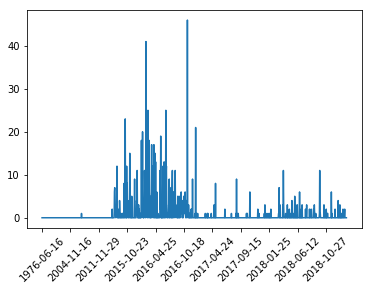

In [51]:
x=[x[0] for x in mexico][::-1]
xticks = x[::100]
y=[x[1] for x in mexico][::-1]
lm = plt.plot(x,y)

plt.xticks(ticks = xticks, rotation=45);
#plt.locator_params(axis='x', nbins=10)

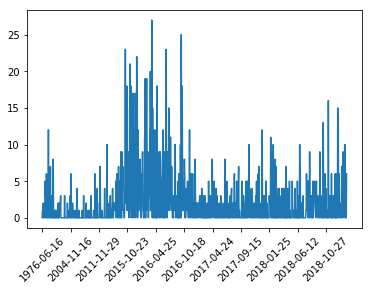

In [52]:
x=[x[0] for x in tremendous][::-1]
xticks = x[::100]
y=[x[1] for x in tremendous][::-1]
lm = plt.plot(x,y)

plt.xticks(ticks = xticks, rotation=45);

In [103]:
datetime.strptime('February 9, 2019', '%B %d, %Y')

datetime.datetime(2019, 2, 9, 0, 0)

## Scattertext - Campaign

In [196]:
nlp = spacy.load('en')
corpus = (st.CorpusFromPandas(speechdf, category_col='candidate', text_col='speech', nlp=nlp)
          .build()
          .remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

Terms that differentiate corpus from general English corpus:

In [197]:
print(list(corpus.get_scaled_f_scores_vs_background().index[:10]))

['obamacare', 'africanamerican', 'obama', 'clintons', 'hillary', 'gon', 'trump', 'wikileaks', 'renegotiate', 'jobkilling']


Top Clinton Terms

In [198]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Clinton Score'] = corpus.get_scaled_f_scores('clinton')
pprint(list(term_freq_df.sort_values(by='Clinton Score', ascending=False).index[:10]))

['stronger together',
 'those at',
 'my dad',
 'just those',
 'america where',
 'fairer',
 'khan',
 'an america',
 'insults',
 'someone who']


Top Trump Terms

In [199]:
term_freq_df = corpus.get_term_freq_df()
term_freq_df['Trump Score'] = corpus.get_scaled_f_scores('trump')
pprint(list(term_freq_df.sort_values(by='Trump Score', ascending=False).index[:10]))

['obamacare',
 'borders',
 'nafta',
 'media',
 'these people',
 'dishonest',
 'trump administration',
 'great people',
 'corrupt',
 'donors']


### Generate viz:

In [55]:
html = st.produce_scattertext_explorer(corpus,
          category='clinton',
          category_name='Clinton',
          not_category_name='Trump',
         width_in_pixels=1000,
         metadata=speechdf['candidate'])
open("Campaign2016-Visualization_stopwords.html", 'wb').write(html.encode('utf-8'))

4291166

## Scattertext- Campaign Topics and Categories

In [59]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus = st.CorpusFromParsedDocuments(speechdf,
                                              category_col='candidate',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='speech').build().remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True)
html = st.produce_scattertext_explorer(empath_corpus,
                                        category='clinton',
                                        category_name='Clinton',
                                        not_category_name='Trump',
                                        width_in_pixels=1000,
                                        metadata=speechdf['candidate'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())
open("Campaign-Empath-stopwords.html", 'wb').write(html.encode('utf-8'))

3808299

## Scattertext - Debates

In [46]:
corpus_d = (st.CorpusFromPandas(debatesdf, category_col='candidate', text_col='args', nlp=nlp)
            .build()
           .remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True))

Terms that differentiate corpus from general English corpus:

In [47]:
print(list(corpus_d.get_scaled_f_scores_vs_background().index[:10]))

['obamacare', 'wikileaks', 'raqqa', 'outsmarted', 'tweeting', 'defunding', 'underleveraged', 'videodonald', 'analysishere', 'debatereporters']


Top Clinton Terms:

In [48]:
term_freq_df = corpus_d.get_term_freq_df()
term_freq_df['Clinton Score'] = corpus_d.get_scaled_f_scores('clinton')
pprint(list(term_freq_df.sort_values(by='Clinton Score', ascending=False).index[:10]))

['need to',
 'that he',
 '’ve got',
 'about what',
 'clear',
 'people who',
 'families',
 'information',
 'hope',
 'try']


In [49]:
term_freq_df = corpus_d.get_term_freq_df()
term_freq_df['Trump Score'] = corpus_d.get_scaled_f_scores('trump')
pprint(list(term_freq_df.sort_values(by='Trump Score', ascending=False).index[:10]))

['tremendous',
 'a disaster',
 'she does',
 'secretary clinton',
 'will tell',
 'she wants',
 'she ’s',
 'cities',
 'inner',
 'bad']


In [43]:
html = st.produce_scattertext_explorer(corpus_d,
          category='clinton',
          category_name='Clinton',
          not_category_name='Trump',
         width_in_pixels=1000,
         metadata=debatesdf['candidate'])
open("Debates-Visualization-stopwords.html", 'wb').write(html.encode('utf-8'))

697121

In [63]:
feat_builder = st.FeatsFromOnlyEmpath()
empath_corpus_d = st.CorpusFromParsedDocuments(debatesdf,
                                              category_col='candidate',
                                              feats_from_spacy_doc=feat_builder,
                                              parsed_col='args').build().remove_terms(ENGLISH_STOP_WORDS, ignore_absences=True)
html = st.produce_scattertext_explorer(empath_corpus_d,
                                        category='clinton',
                                        category_name='Clinton',
                                        not_category_name='Trump',
                                        width_in_pixels=1000,
                                        metadata=debatesdf['candidate'],
                                        use_non_text_features=True,
                                        use_full_doc=True,
                                        topic_model_term_lists=feat_builder.get_top_model_term_lists())
open("Debates-Empath.html", 'wb').write(html.encode('utf-8'))

797933

# Topic Modeling

In [8]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [9]:
def get_speech_topics(candidate, vectorizer, n_comp): 
    vectorizer = vectorizer
    args = speechdf.loc[(speechdf.candidate == candidate), 'speech']
    vectorized = vectorizer.fit_transform(args)
    nmf_model = NMF(n_components= n_comp, init='random', random_state=0)
    doc_topic = nmf_model.fit_transform(vectorized)
    display_topics(nmf_model, vectorizer.get_feature_names(), 20)
    return doc_topic

stop_words = ENGLISH_STOP_WORDS.union([ 'youre', 'doesnt'])

# Topic Modeling: By Speech


Clinton's main topics appear to be **Jobs/Business, Education/Healthcare, Community/Faith,** and  **Military**:

In [25]:
model = get_speech_topics('clinton', CountVectorizer(stop_words='english', max_df=.86), n_comp=4)


Topic  0
tax, pay, businesses, workers, companies, lets, business, create, trade, able, corporations, plan, taxes, michigan, big, billion, build, million, long, wants

Topic  1
pay, college, youre, hes, rights, kids, education, job, health, big, women, talk, school, state, hope, debt, heres, person, high, actually

Topic  2
service, church, black, love, communities, job, faith, white, lives, doesnt, lets, latino, community, kids, obama, reform, stand, build, school, children

Topic  3
nuclear, military, women, weapons, veterans, national, state, men, allies, united, war, nation, service, commander, doesnt, republicans, maybe, security, doing, stand


In [245]:
topic_dist = Counter([x.argmax() for x in model])

In [246]:
topic_dist

Counter({2: 8, 1: 21, 0: 3, 3: 4})

Trump's main topics are harder to decipher. **Mexico/Immigration** and **Obama Administration** seem to be the most prevalent, with other topics like **Jobs/Deals**, **Media**, and **ISIS** showing up here and there. It seems that Trump speeches each tend to cover a few different topic:

In [53]:
model = get_speech_topics('trump', CountVectorizer(stop_words='english', max_df=.85), n_comp=4)


Topic  0
guy, oh, story, doesn, little, talking, virginia, deals, mexico, actually, wall, probably, saw, talk, nice, million, different, wouldn, went, yes

Topic  1
african, future, immigration, millions, school, policies, cities, children, law, isis, million, crime, november, poverty, inner, plan, security, energy, illegal, education

Topic  2
borders, florida, illegal, obamacare, debate, administration, th, cities, taxes, oh, plan, criminal, media, wall, corrupt, november, leaving, isis, movement, mexico

Topic  3
gonna, million, mexico, ohio, number, hampshire, tax, obamacare, numbers, leave, wanna, thousands, away, dishonest, question, heroin, michigan, use, wouldn, simple


# Topic Modeling, by sentence

## Break Trump speeches into sentences:

In [81]:
## MAKE SURE  LAST LINE IN CELL 4 (removing punctuation) is commented out

trumpspeeches = speechdf.loc[(speechdf.candidate == 'trump'),'speech'].tolist()  #list of speeches
trumpdates = [re.findall('(?<=Trump_).*(?=.txt)', x)[0] for x in speechdf.loc[(speechdf.candidate == 'trump')].index]
trumpsents = list(map(lambda speech: sent_tokenize(speech), trumpspeeches))    #list of lists of sentences
trumpsentences = [el for l in trumpsents for el in l]    # long list of sentences


trumpsentences_idx = [(i, sent) for i, sent in enumerate(trumpsents)]    #trumpsentences with index of speech

In [42]:
# index each sentence with index of speech it came from

indexed = []
for sent in trumpsentences_idx:
    i = sent[0]
    for line in sent[1]:
        indexed.append((i,line))

In [43]:
## Vectorize, train NMF model and print topics

vectorizer = CountVectorizer(stop_words='english', max_df=.005)
args = trumpsentences
vectorized = vectorizer.fit_transform(args)
nmf_model = NMF(n_components= 7, init='random', random_state=0)
doc_topic = nmf_model.fit_transform(vectorized)
display_topics(nmf_model, vectorizer.get_feature_names(), 20)


Topic  0
millions, dollars, energy, billions, small, create, hundreds, including, businesses, children, workers, trillions, poverty, schools, tens, hispanic, policies, help, donors, killing

Topic  1
carolina, north, leave, pennsylvania, florida, ohio, leaving, hampshire, places, michigan, winning, manufacturing, leading, workers, york, family, company, strong, signed, house

Topic  2
second, amendment, court, supreme, save, justices, appoint, defend, constitution, siege, uphold, protect, family, replace, fifth, includes, forget, judges, congress, proud

Topic  3
school, children, education, common, child, provide, means, private, core, poverty, schools, public, parents, local, magnet, religious, charter, best, family, home

Topic  4
immigration, criminal, fbi, general, open, interests, horrible, security, radical, community, home, department, wouldn, national, secretary, bernie, foreign, donors, office, anybody

Topic  5
law, enforcement, support, women, men, police, order, federal, 

**Topic 0: Jobs  
Topic 1: U.S. Industry  
Topic 2: Judicial Branch  
Topic 3: Education  
Topic 4: Immigration  
Topic 5: Law Enforcement  
Topic 6: Middle East**

In [44]:
# zip sentences with their topic distribution
dist = list(zip(indexed,doc_topic))

# make each sentence's topic a hard vote. Make dict where key = speech index, value = list of sentence topics
sentence = [x[0][0] for x in dist]
topic = [np.argmax(x[1]) for x in dist]

trumpdist = defaultdict(list)
for i in list(zip(sentence, topic)):
    trumpdist[str(i[0])].append(i[1])

# Turn dictionary into list of topic distributions for each speech
def get_dist():
    dist = []
    for key in trumpdist.keys():
        l = trumpdist[key]
        c = Counter(l)
        dist.append([(i, c[i] / len(l) * 100.0) for i in c])
    return dist

trump_topic_dist = get_dist()

In [45]:
# organize data into columns and 

def data_organize(data):
    output = []
    for row in data:
        data_row = []
        for i in range(7):
            flag = True
            for point in row:
                if point[0] == i:
                    flag = False
                    data_row.append(point[1])
            if(flag):
                data_row.append(0)
        output.append(data_row)
    return output

In [47]:
trump_org_data = data_organize(trump_topic_dist)

In [48]:
trump_dist_df = pd.DataFrame(data=trump_org_data)

In [52]:
trump_dist_df.head()

0          1         2         3          4         5         6
0  23.882897   9.244992  2.465331  3.852080  54.237288  2.773498  3.543914
1  28.953488  10.465116  1.976744  4.069767  50.348837  1.511628  2.674419
2  24.352332   3.108808  1.554404  6.217617  53.886010  4.663212  6.217617
3  19.097222  10.763889  0.694444  1.273148  61.226852  3.356481  3.587963
4  34.421642  12.500000  1.119403  3.078358  43.936567  2.425373  2.518657

In [53]:
#trump_dist_df.to_csv('trump_topic_dist.csv')

In [58]:
def plot_trumpdist(distdf):
    for i in np.arange(7):
        x = trumpdates
        y = distdf[i]
        plt.plot(x,y)
        plt.legend()
        plt.xticks(ticks =x[::2],rotation=45)

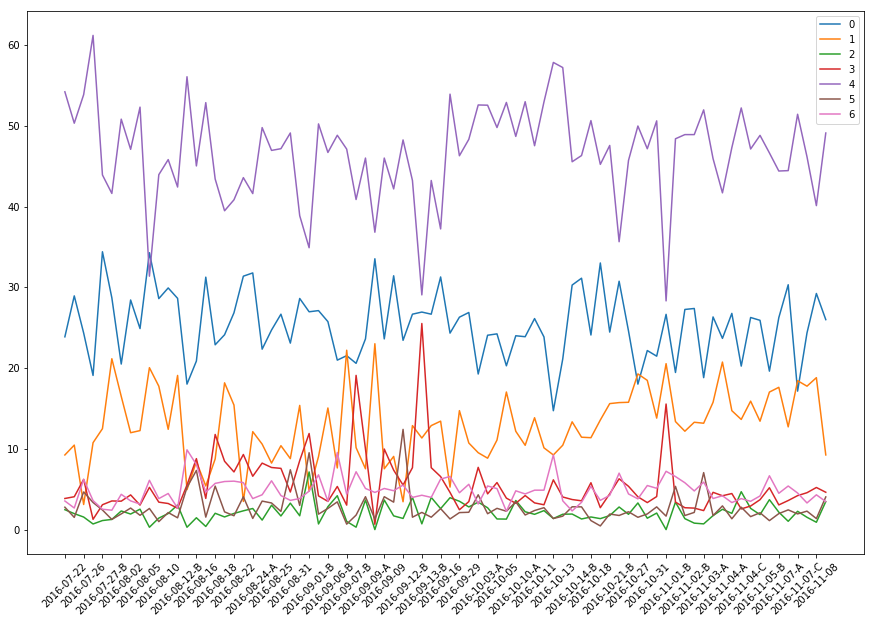

In [59]:
plt.figure(figsize=(15,10))
plot_trumpdist(trump_dist_df)

## Hillary by sentence

In [10]:
## MAKE SURE  LAST LINE IN CELL 4 (removing punctuation) is commented out

hilspeeches = speechdf.loc[(speechdf.candidate == 'clinton'),'speech'].tolist()
hildates = [re.findall('(?<=Clinton_).*(?=.txt)', x)[0] for x in speechdf.loc[(speechdf.candidate == 'clinton')].index]
hilsents = list(map(lambda speech: sent_tokenize(speech), hilspeeches)) 
hilsentences = [el for l in hilsents for el in l]


hilsentences_idx = [(i, sent) for i, sent in enumerate(hilsents)]

In [11]:
# index each sentence with index of speech it came from

indexed = []
for sent in hilsentences_idx:
    i = sent[0]
    for line in sent[1]:
        indexed.append((i,line))

In [32]:
## Vectorize, train NMF model and print topics

vectorizer = CountVectorizer(stop_words='english', max_df=.005)
args = hilsentences
vectorized = vectorizer.fit_transform(args)
nmf_model = NMF(n_components= 7, init='random', random_state=0)
doc_topic = nmf_model.fit_transform(vectorized)
display_topics(nmf_model, vectorizer.get_feature_names(), 25)


Topic  0
khan, son, insults, serving, captain, muslims, iraq, mr, star, immigrants, hampshire, gold, african, killed, honor, manchester, latinos, khizr, introduced, insulted, insulting, disabilities, pows, mexican, attacks

Topic  1
table, screen, silk, paint, squeegee, pour, fabric, lift, plant, old, printed, ran, draperies, tables, printing, fashioned, lay, pick, fabrics, screens, print, idea, silkscreen, push, asking

Topic  2
black, colleges, free, universities, tuition, church, historically, strength, owned, excellence, vibrancy, latino, idea, success, field, university, generation, bernie, parents, african, programs, sanders, question, missing, watching

Topic  3
wage, raise, minimum, left, poverty, living, raising, equal, places, income, low, cost, guarantee, competing, shouldn, won, percent, federal, coal, cities, towns, middleclass, neighborhoods, leave, comes

Topic  4
street, wall, corporations, trillions, wealthy, millionaires, cuts, share, billionaires, rules, managers, s

**Topic 0: Humayun Khan and Immigrants in U.S.   
Topic 1: Clinton's father's silk screen factory  
Topic 2: Education    
Topic 3: Minimum Wage  
Topic 4: Wall Street  
Topic 5: Foreign Affairs  
Topic 6: American People**


In [16]:
dist = list(zip(indexed,doc_topic))

sentence = [x[0][0] for x in dist]
topic = [np.argmax(x[1]) for x in dist]

hildist = defaultdict(list)
for i in list(zip(sentence, topic)):
    hildist[str(i[0])].append(i[1])

def get_dist():
    dist = []
    for key in hildist.keys():
        l = hildist[key]
        c = Counter(l)
        dist.append([(i, c[i] / len(l) * 100.0) for i in c])
    return dist

hil_topic_dist = get_dist()

In [27]:
def data_organize(data):
    output = []
    for row in data:
        data_row = []
        for i in range(7):
            flag = True
            for point in row:
                if point[0] == i:
                    flag = False
                    data_row.append(point[1])
            if(flag):
                data_row.append(0)
        output.append(data_row)
    return output

In [28]:
hil_org_data = data_organize(hil_topic_dist)

In [113]:
hil_dist_df = pd.DataFrame(data=hil_org_data)

In [114]:
hil_dist_df.to_csv('hil_dist_df.csv')

In [115]:
def plot_hildist(distdf):
    for i in np.arange(7):
        x = hildates
        y = distdf[i]
        plt.plot(x,y)
        plt.legend()
        plt.xticks(rotation=45)

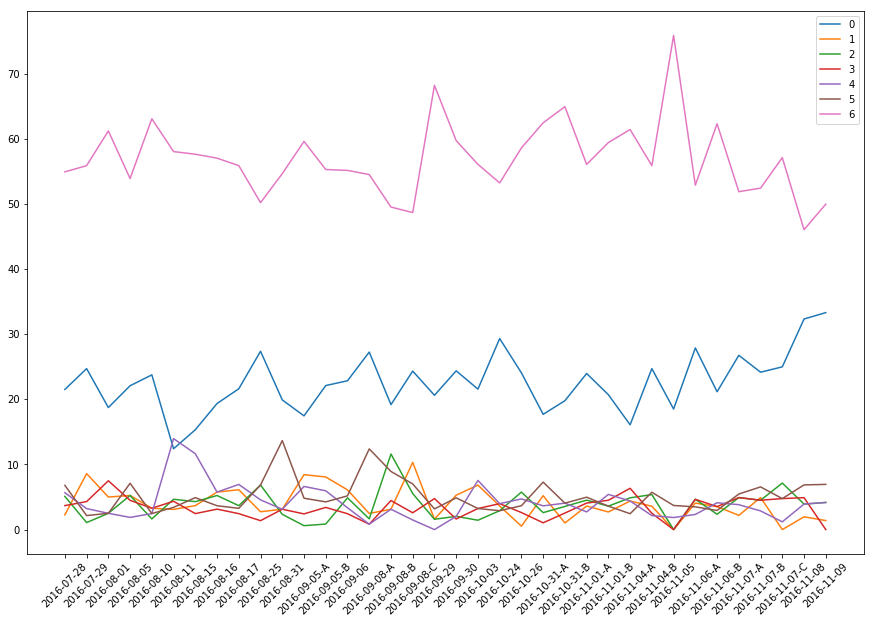

In [116]:
plt.figure(figsize=(15,10))
plot_hildist(hil_dist_df)

## Topic Modeling: Debates 


In [91]:
#Get candidate topics from debate with a given vectorizer
    
def get_debate_topics(debate, candidate, vectorizer, n_comp): 
    vectorizer = vectorizer
    args = debate.loc[(debate.candidate == candidate), 'args']
    sents = list(map(lambda arg: sent_tokenize(arg), args)) 
    sentences = [el for l in sents for el in l]
    vectorized = vectorizer.fit_transform(sentences)
    nmf_model = NMF(n_components= n_comp, init='random', random_state=0)
    doc_topic = nmf_model.fit_transform(vectorized)
    display_topics(nmf_model, vectorizer.get_feature_names(), 30)

### Debate 1

#### Clinton Topics:

In [210]:
get_debate_topics(debate_1, 'clinton', CountVectorizer(stop_words='english', max_df=.05, ngram_range=(1,2)), 9)


Topic  0
looked, jobs, million, said, economy, proposed, ve said, million jobs, debt, plans, recession, lose, 10, lose million, looked plans, 10 million, tax, new jobs, investments, trillion

Topic  1
isis, able, country, support, actually, people country, end, companies, prevent, europe, claim, direct, think need, making, progress, country europe, intensify, partners, partners able, raqqa

Topic  2
business, jobs, new, new jobs, taken, small, small business, means, come, work, good, say, manufacturing, pay, actually, clean, energy, did, refused, refused pay

Topic  3
years, federal, tax, paid, taxes, american, maybe, income, income tax, paid federal, federal income, state, pay, trying, american people, tonight, seen, turn, didn, couple

Topic  4
troops, american, government, iraq, american troops, iraqi government, iraqi, agreement, let, talk, lester, obama, barack obama, barack, question, says, let talk, asked, question asked, leave

Topic  5
make, information, foreign, money, state

#### Trump topics

In [92]:
get_debate_topics(debate_1, 'trump', CountVectorizer(stop_words='english', max_df=.1, ngram_range=(1,2)), 6)


Topic  0
country, money, bring, companies, going, leaving, bring money, billions, taxes, trillion, thing, great, like, doing, land, leaving country, red, red tape, tape, bureaucratic, bureaucratic red, world, billions dollars, dollars, politicians, bad, like secretary, billions billions, companies going, great thing

Topic  1
secretary, clinton, secretary clinton, isis, ve, got, obama, internet, years, way, control, time, agree, laws, president, president obama, created, came internet, doing, think, came, nato, talks, ll, want, saying, long time, obama secretary, vacuum, taken

Topic  2
think, don, know, really, don think, stop, frisk, stop frisk, say, murders, really don, maybe, want, believe, truth, know truth, don believe, want know, 200, york city, 500, reason say, reason, disagree, new york, york, brought, brought 500, believe new, 500 murders

Topic  3
people, chicago, 000, killed, bad, thousands, obama, barack, barack obama, people killed, 000 people, shouldn, people shouldn, n

### Debate 2

#### Clinton Topics

In [97]:
get_debate_topics(debate_2, 'clinton', CountVectorizer(stop_words='english',max_df=.05, ngram_range=(1,2)), 9)


Topic  0
women, advocating, make, care, children, work, better, make sure, health care, sure, secretary, secretary state, state, hundreds, thousands, hundreds thousands, life, health, able, went, better life, chance, russia, did, nuclear, nuclear weapons, weapons, treaty, law, national

Topic  1
goals, work, making, big, set, big goals, america, make, sure, campaign, making sure, education, best, americans, getting, instead, opinion, affordable, forth, try, work just, sets americans, divisiveness sets, set forth, best education, set goals, sets, affordable set, instead make, divisiveness

Topic  2
great, russian, really, election, american, let, influence, putin, martha, influence election, intelligence, talk, community, thought, meaning, directing attacks, display, martha intelligence, display presidential, meaning putin, directing, days, days kremlin, community just, came said, came, american accounts, presidential leadership, said days, putin russian

Topic  3
debate, trump, donald

#### Trump Topics

In [98]:
get_debate_topics(debate_2, 'trump', CountVectorizer(stop_words='english',max_df=.05, ngram_range=(1,2)), 10)


Topic  0
percent, deal, things, health, really, state, potential, watch, look, ve, billion, iran, care, years, tremendous, 150, iran deal, 150 billion, health care, numbers, doing, obamacare, ago, horrible, years ago, number, bad, health insurance, going numbers, just

Topic  1
million, 30, 30 million, think, don, 100, 100 million, tell, campaign, 25, 25 million, american, really, 20, exactly, american public, public, nice, funding, sign, tell exactly, million special, sign american, 20 million, million campaign, isn funding, isn, interests tell, interests, million 20

Topic  2
bad, judgment, bad judgment, bernie sanders, sanders, bernie, said, ve, really, tell, sanders said, really bad, people country, seen, problems, ve seen, murderers, letting, country going, judgment letting, going cause, letting people, strongly bernie, tell strongly, judgment really, problems crime, like ve, said bad, bad people, crime

Topic  3
ve, new, hillary, york, new york, heard, cities, wise, inner, inner

### Debate 3

#### Clinton Topics

In [99]:
get_debate_topics(debate_3, 'clinton', CountVectorizer(stop_words='english',max_df=.05, ngram_range=(1,2)), 9)


Topic  0
immigrants, undocumented, employers, economy, lot, exploit, shadows, undocumented immigrants, mexican, clear, look, good, best, new, deal, proposing, started, americans, campaign, donald proposing, knows lot, good employers, dealers, knows, criminals, economy good, shadows putting, new technology, immigrants arguing, immigrants calling

Topic  1
parenthood, planned, planned parenthood, defunding, defunding planned, america, states, right, donald said, course, choice, kinds, regulations, happening, benefits, putting, putting stringent, kinds cancer, favor defunding, course provides, women block, america states, country donald, parenthood course, favor, choice extent, provides, screenings benefits, women country, exercising

Topic  2
years, ahead, 30, 30 years, let, american, help, ll, experience, justice, way, years experience, bin laden, bin, celebrity apprentice, celebrity, brought, apprentice, laden, stay ahead, stay, ahead stay, families, trying, trying help, kids, happy, 

#### Trump Topics

In [100]:
get_debate_topics(debate_3, 'trump', CountVectorizer(stop_words='english',max_df=.05, ngram_range=(1,2)), 9)


Topic  0
millions, vote, registered, registered vote, look, millions people, just, coming, people registered, let, let just, thing, places, report, shouldn, chris, excuse, places millions, rolls millions, pew report, pew, millions isn, rolls, report places, shouldn registered, coming pew, chris look, coming coming, look excuse, excuse chris

Topic  1
iran, mosul, wanted, ago, leaders, iraq, going mosul, thank, write, write letter, iran write, letter, taking, years, said, taking iraq, iran taking, years ago, isis, wanted leaders, want, deal, really, iraq ve, saying thank, iran said, said years, forever, easy going, forever ve

Topic  2
clinton, hillary, assad, happened, hillary clinton, lot, tougher, obama, trump, just, debate, thought, tougher thought, say, sad, fighting, oh, smarter, turned, lot hillary, smarter obama, happened lot, oh loves, just tougher, lot tougher, thought going, going say, say oh, happened fighting, tougher smarter

Topic  3
money, build, went, house build, fish

In debate 1, Clinton discusses her plans and positions on **Jobs, Isis, Police Bias, Minorities in the Justice System, the Military, and the Middle Class.** By debate 3, she focuses more on Trump and his policies. 

# WORD 2 VEC

## GENSIM WORD2VEC SPEECHES -- TRUMP

In [101]:
def display_closestwords_tsnescatterplot(model, word):
    
    arr = np.empty((0,100), dtype='f')
    word_labels = [word]

    # get close words
    close_words = model.most_similar(word, topn = 30)
    
    # add the vector for each of the closest words to the array
    arr = np.append(arr, np.array([model[word]]), axis=0)
    for wrd_score in close_words:
        wrd_vector = model[wrd_score[0]]
        word_labels.append(wrd_score[0])
        arr = np.append(arr, np.array([wrd_vector]), axis=0)
        
    # find tsne coords for 2 dimensions
    tsne = TSNE(n_components=2, random_state=0)
    np.set_printoptions(suppress=True)
    Y = tsne.fit_transform(arr)

    x_coords = Y[:, 0]
    y_coords = Y[:, 1]
    # display scatter plot
    plt.figure(figsize=(10,10))
    plt.scatter(x_coords, y_coords)

    for label, x, y in zip(word_labels, x_coords, y_coords):
        plt.annotate(label, xy=(x, y), xytext=(0, 0), textcoords='offset points', size=14)
    plt.xlim(x_coords.min()+0.5, x_coords.max()+0.5)
    plt.ylim(y_coords.min()+0.5, y_coords.max()+0.5)
    plt.show()

In [160]:
trumpspeeches = speechdf.loc[(speechdf.candidate == 'trump'),'speech'].tolist()
#trumpdebates = debatesdf.loc[(debatesdf.candidate == 'trump'),'args'].tolist()
#trumpspeeches.extend(trumpdebates)

trumptexts = [speech.lower().split() for speech in trumpspeeches]
trumptexts_stopwords = list(map(lambda x: [y for y in x if y not in ENGLISH_STOP_WORDS], trumptexts))

In [163]:
trumpmodel = models.Word2Vec(trumptexts_stopwords, size=100, window=5, min_count=1, workers=2, sg=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyke

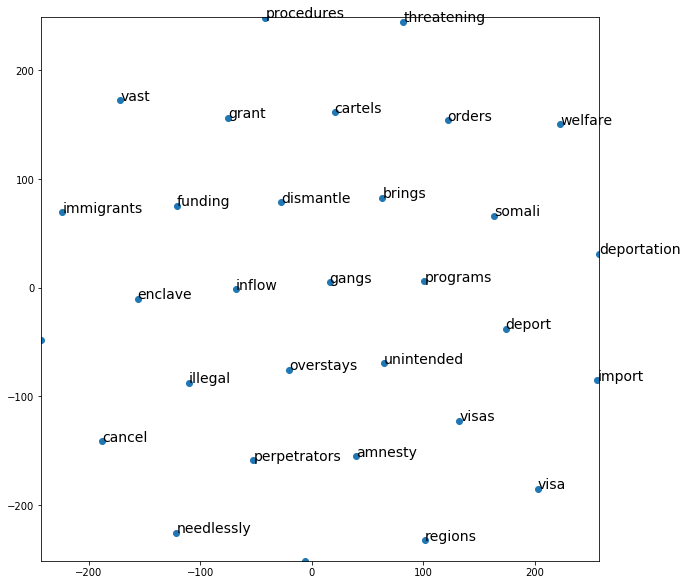

In [166]:
display_closestwords_tsnescatterplot(trumpmodel, 'immigrants')

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyke

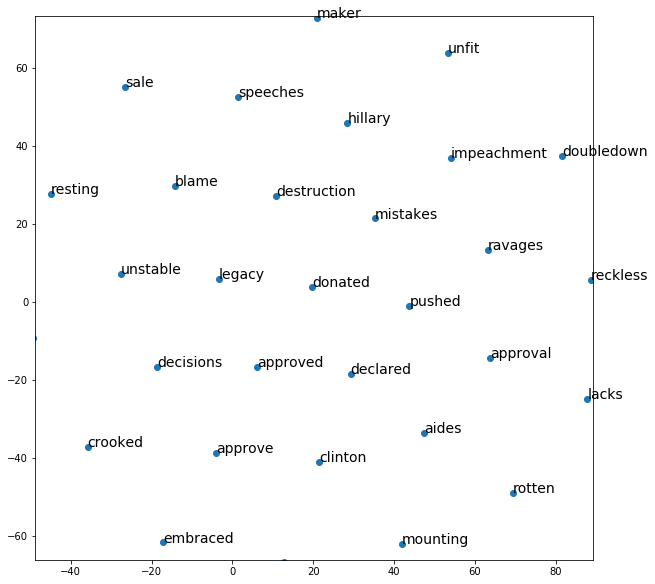

In [174]:
display_closestwords_tsnescatterplot(trumpmodel, 'hillary')

In [73]:
trumpmodel.most_similar(positive=['america', 'immigrants'], negative=['good'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('aliens', 0.639583945274353),
 ('duty', 0.6318255662918091),
 ('visas', 0.629105806350708),
 ('welfare', 0.6265219449996948),
 ('dismantle', 0.6166352033615112),
 ('bigotry', 0.6154305934906006),
 ('unlimited', 0.6143003702163696),
 ('cartel', 0.6005228757858276),
 ('gangs', 0.6002650856971741),
 ('illegal', 0.59172523021698)]

In [75]:
trumpmodel.most_similar(positive=['hillary', 'clinton'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('crooked', 0.7661576271057129),
 ('clintons', 0.7285541892051697),
 ('rodham', 0.7122288346290588),
 ('rotten', 0.6990715265274048),
 ('barack', 0.6816103458404541),
 ('speeches', 0.67393958568573),
 ('embraced', 0.6668707132339478),
 ('machine', 0.6646813154220581),
 ('caused', 0.6587756872177124),
 ('reckless', 0.6577965021133423)]

## GENSIM WORD2VEC SPEECHES -- CLINTON

In [167]:
hilspeeches = speechdf.loc[(speechdf.candidate == 'clinton'),'speech'].tolist()
#hildebates = debatesdf.loc[(debatesdf.candidate == 'clinton'),'args'].tolist()
#hilspeeches.extend(hildebates)

hiltexts = [word.lower().split() for word in hilspeeches]
hiltexts_stopwords = list(map(lambda x: [y for y in x if y not in ENGLISH_STOP_WORDS], hiltexts))

In [168]:
hilmodel = models.Word2Vec(hiltexts_stopwords, size=100, window=5, min_count=1, workers=2, sg=1)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:12: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipyke

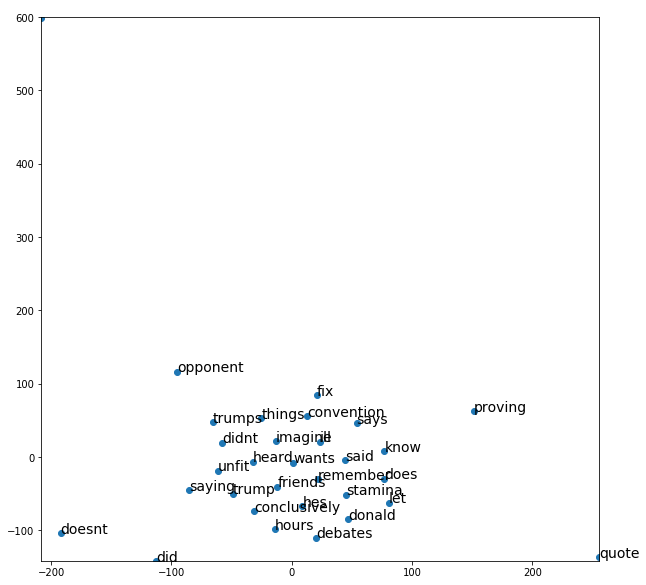

In [175]:
display_closestwords_tsnescatterplot(hilmodel, 'trump')

In [108]:
hilmodel.most_similar(positive=['donald', 'trump'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('trump,', 0.9159584045410156),
 ("trump's", 0.8998342156410217),
 ('says', 0.8959823250770569),
 ('he', 0.8872672319412231),
 ('has', 0.8793655633926392),
 ('him', 0.8747357130050659),
 ('said', 0.870494544506073),
 ('unfit', 0.8686469793319702),
 ('does', 0.8684629201889038),
 ('trump.', 0.8665366172790527)]

In [105]:
hilmodel.most_similar(positive=['america', 'immigrant'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('marriage', 0.9756702184677124),
 ('discrimination', 0.9734779596328735),
 ('which', 0.9731550812721252),
 ('place,', 0.9731157422065735),
 ('military', 0.9701194763183594),
 ('independent', 0.9698617458343506),
 ('walls.', 0.9694428443908691),
 ('role', 0.9692699909210205),
 ('respected...', 0.9677268266677856),
 ('wrong...', 0.9675015807151794)]

## WORD 2 VEC TRUMP (all speeches from FactBase)

In [8]:
trump_all[0] = trump_all[0].apply(lambda x: re.sub("[^\w ]" ,'',x))
trumpall_speeches = trump_all[0]
trumpall_texts = [word.lower().split() for word in trumpall_speeches]

<>:1: DeprecationWarning:

invalid escape sequence \w

<>:1: DeprecationWarning:

invalid escape sequence \w

<>:1: DeprecationWarning:

invalid escape sequence \w

<ipython-input-8-913550704dbb>:1: DeprecationWarning:

invalid escape sequence \w



In [9]:
trumpallmodel = models.Word2Vec(trumpall_texts, size=100, window=5, min_count=5, workers=2, sg=1)

In [10]:
trumpallmodel.most_similar(positive=['woman','president'], negative=['man'])

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:1: DeprecationWarning:

Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).



[('she', 0.505669116973877),
 ('herself', 0.49101972579956055),
 ('stamina', 0.4865880012512207),
 ('thatd', 0.47956717014312744),
 ('vice', 0.45714330673217773),
 ('unfit', 0.4496724009513855),
 ('obama', 0.4464558959007263),
 ('candidate', 0.4442570209503174),
 ('chosen', 0.43981775641441345),
 ('transparent', 0.4379258453845978)]

In [11]:
labels = []
tokens = []
for word in trumpallmodel.wv.vocab:
    tokens.append(trumpallmodel[word])
    labels.append(word)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning:

Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_

In [12]:
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500)
new_values = tsne_model.fit_transform(tokens)
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

In [15]:
init_notebook_mode(connected=True)
plot_data = go.Scatter(x=x,
                       y=y,
                       mode='markers+text',
                       marker = dict(
                           size = 4,
                           color = '#2abdbd'),
                       text=labels,
                       textposition='top left',
                       textfont=dict(
                           family='calibri',
                           size=12,
                           color='#4f6978')
                      )

layout = go.Layout(
    xaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    ),
    yaxis=dict(
        autorange=True,
        showgrid=False,
        zeroline=False,
        showline=False,
        ticks='',
        showticklabels=False
    )
)
fig = go.Figure(data=[plot_data], layout=layout)
url = py.plot(fig, filename='pandas-3d-iris', validate=False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/F

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/F

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/numpy/lib/type_check.py:546: DeprecationWarning:

np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead

/Library/F

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



text stat , gunning fog PyPi